---
# **1. Insallations**
---

In [1]:
!pip install nltk
!pip install --upgrade git+https://github.com/flairNLP/flair.git
!pip install textblob
!pip install stanza
!pip install spacy
!pip install tqdm

  Cloning https://github.com/flairNLP/flair.git to /tmp/pip-req-build-esa7h6sc
  Running command git clone -q https://github.com/flairNLP/flair.git /tmp/pip-req-build-esa7h6sc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 983kB 4.0MB/s 
     |████████████████████████████████| 1.1MB 17.0MB/s 
     |████████████████████████████████| 1.1MB 19.5MB/s 
     |████████████████████████████████| 19.7MB 156kB/s 
     |████████████████████████████████| 798kB 56.2MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 276kB 46.6MB/s 
     |████████████████████████████████| 3.0MB 42.9MB/s 
     |████████████████████████████████| 890kB 44.9MB/s 
  Created wheel for flair: filename=flair-0.6.1-cp36-none-any.whl size=201257 sha256=09c26df05f69c12da38a008ed8e99bd477019908d6b8920fdd31cad85d88553d
  Stored in directory: /tmp/pip-ephem-wheel-cac

---
# **2. Imports**
---

In [131]:
import re
import logging
import requests
import io
import pandas as pd
pd.options.mode.chained_assignment = None # default='warn'

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from time import sleep

In [3]:
from textblob import TextBlob

In [4]:
import flair
flair_sent = flair.models.TextClassifier.load('en-sentiment')

2020-10-07 00:28:18,515 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_3.1.pt not found in cache, downloading to /tmp/tmpyrp2fitn


100%|██████████| 266147697/266147697 [00:11<00:00, 22392681.04B/s]

2020-10-07 00:28:30,756 copying /tmp/tmpyrp2fitn to cache at /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


2020-10-07 00:28:31,529 removing temp file /tmp/tmpyrp2fitn
2020-10-07 00:28:31,564 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

SIA = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
import stanza
stanza.download('en', package='ewt', processors='tokenize,sentiment,pos', verbose=True)
stanza.download('en', package='default', processors='tokenize,sentiment', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,sentiment,pos', lang='en', use_gpu=True)

2020-10-07 00:28:48 WARNING: Can not find sentiment: ewt from official model list. Ignoring it.
2020-10-07 00:28:48 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| pretrain  | ewt     |

2020-10-07 00:30:35 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-10-07 00:30:36 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| sentiment | sstplus |
| pretrain  | ewt     |

2020-10-07 00:30:36 INFO: File exists: /root/stanza_resources/en/tokenize/ewt.pt.
2020-10-07 00:30:48 INFO: File exists: /root/stanza_resources/en/pretrain/ewt.pt.
2020-10-07 00:30:48 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-10-07 00:30:48 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tok

In [7]:
import spacy
spNLP = spacy.load("en_core_web_sm")

---
# **3. NLP functions**
---

In [8]:
def text_blob_subjective(text):
    return TextBlob(text).sentiment

In [9]:
def flair_lstm(text):
    x = flair.data.Sentence(text)
    flair_sent.predict(sentences=x)
    return x.labels

In [10]:
def stanza_funct(text):
    try:
        data = stNLP(text)
        for sentence in data.sentences:
            return sentence.sentiment
    except:
        print('{...}', end='; ')

---
# **4. Preprocessing**
---

Words play a central role in language and thought. Several influential factor analysis studies have shown that
the primary dimensions of word meaning are valence, arousal, and dominance (VAD).
- valence is the positive--negative or pleasure--displeasure dimension; 
- arousal is the excited--calm or active--passive dimension; 
- dominance is the powerful--weak or 'have control'--'have no control' dimension.

```
Each line has the following format:
<AffectCategory><tab><term><tab><score>
<AffectCategory> is one of eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, or disgust).
<term> is a word for which emotion associations are provided.
<score> is a value that indicates the strength of association between the <term> and the <AffectCategory>.
The higher the value, the stronger is the association. Refer to the publications below for details on how the score is calculated.
```


## Loading datasets lexicon

### Donwload datasets to dir

In [11]:
def download_datasets():
    #!mkdir -p datasets
    !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Emotion-Lexicon-Wordlevel-v0.92.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Hashtag-Emotion-Lexicon-v0.2.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-VAD-Lexicon.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/emobank.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/isear.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/checkpoint-bywords.csv -P datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/dataset_checkpoint.csv -P datasets

In [12]:
# uncomment if you want to download the datasets to ./datasets folder
#download_datasets()

### URLS

In [13]:
NRC_Emotion_Intensity_Lexicon = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Emotion-Intensity-Lexicon-v1.csv'

In [14]:
NRC_Emotion_Lexicon_Wordlevel = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Emotion-Lexicon-Wordlevel-v0.92.csv'

In [15]:
NRC_Hashtag_Emotion_Lexicon = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-Hashtag-Emotion-Lexicon-v0.2.csv'

In [16]:
NRC_VAD_Lexicon = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/NRC-VAD-Lexicon.csv'

In [17]:
emobank = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/emobank.csv'

In [18]:
isear = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/isear.csv'

In [19]:
twitter_expanded = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/expanded%20twitter%20dataset.csv'

In [20]:
url_checkpoint_byWords = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/checkpoint-bywords.csv'

In [21]:
checkpoint_url = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/dataset_checkpoint.csv'

In [22]:
spacy_checkpoint = 'https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/spacy_checkpoint.csv'

### Requests

In [23]:
def request_csv(url):
    return (requests.get(url).content).decode('utf-8')

### Loading datasets as requests
Anyway the datasets files were downloaded on ./datasets/ folder

In [24]:
df_NRC_Emotion_Intensity = pd.read_csv(io.StringIO(request_csv(NRC_Emotion_Intensity_Lexicon)), sep='\t')

In [25]:
df_NRC_Hashtag = pd.read_csv(io.StringIO(request_csv(NRC_Hashtag_Emotion_Lexicon)), sep='\t')

In [26]:
df_NRC_Emotion_Wordlevel = pd.read_csv(io.StringIO(request_csv(NRC_Emotion_Lexicon_Wordlevel)), sep='\t')

In [27]:
# by sentece
df_isear = pd.read_csv(io.StringIO(request_csv(isear)), sep='|', error_bad_lines=False, usecols=['SIT', 'Field1'])

In [28]:
df_isear

,Field1,SIT
0,joy,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,disgust,The time I knocked a deer down - the sight of ...
...,...,...
7661,anger,Two years back someone invited me to be the tu...
7662,sadness,I had taken the responsibility to do something...
7663,disgust,I was at home and I heard a loud sound of spit...
7664,shame,I did not do the homework that the teacher had...


### Column names & merge (concatenate)

In [29]:
df_NRC_Hashtag.columns = ['category', 'word', 'score']
df_NRC_Emotion_Intensity.columns = ['word', 'category', 'score']
df_NRC_Emotion_Wordlevel.columns = ['word', 'category', 'score']
df_isear.columns = ['category', 'sentence']

In [30]:
df_concat = pd.concat(objs=[df_NRC_Hashtag, df_NRC_Emotion_Intensity, df_NRC_Emotion_Wordlevel], ignore_index=True)

### Sorting concatenated dataset

In [31]:
df_concat = df_concat.sort_values(by=['category'], ascending=True, ignore_index=True)

## Loading datasets Valence Arousal Dominance

In [32]:
# by word
df_NRC_VAD_Lexicon = pd.read_csv(io.StringIO(request_csv(NRC_VAD_Lexicon)), sep='\t')

In [33]:
df_NRC_VAD_Lexicon[df_NRC_VAD_Lexicon['Word'].str.contains('extremely positive', na=False)]

,Word,Valence,Arousal,Dominance
6384,extremely positive,0.993,0.73,0.839


In [34]:
# by sentence 
df_emobank = pd.read_csv(io.StringIO(request_csv(emobank)), sep=',', usecols=['split', 'text', 'V', 'A', 'D'])

In [35]:
df_emobank

,split,V,A,D,text
0,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,test,2.80,3.10,2.80,If I wasn't working here.
2,train,3.00,3.00,3.00,".."""
3,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...
...,...,...,...,...,...
10057,train,3.00,3.50,3.00,Please let it be a constant reminder of all yo...
10058,train,3.80,3.40,3.60,That’s why I want to extend my appreciation fo...
10059,train,3.00,3.00,3.10,And why I’m writing you today to ask you to re...
10060,train,3.33,3.44,3.44,"In fact, I want to urge you to strengthen your..."


## Loading Twitter expanded dataset

In [36]:
twitter = pd.read_csv(io.StringIO(request_csv(twitter_expanded)))

In [37]:
twitter

,words
0,aw
1,thats
2,a
3,bummer
4,you
...,...
391774,sunoudy
391775,nemuselo
391776,holce
391777,everitt


### Column names

In [38]:
df_NRC_VAD_Lexicon.columns = ['word', 'Valence', 'Arousal', 'Dominance']
df_emobank.columns = ['split', 'Valence', 'Arousal', 'Dominance', 'sentece']

## Plotters: simple plot & bar

In [39]:
def simple_plot(x, y, size):
    plt.figure(figsize=size)
    plt.plot(x, y, linestyle='solid', color='red')
    plt.xlabel('labels')
    plt.ylabel('scores')
    plt.legend(loc='upper left')
    plt.xticks(size=10, rotation='vertical')
    plt.yticks(size=10)
    plt.grid(b=True)
    
    plt.show()

def simple_bar(x, y, size):
    plt.figure(figsize=size)
    plt.bar(x, y, linestyle='solid', color='red')
    plt.xlabel('labels')
    plt.ylabel('scores')
    plt.legend(loc='upper left')
    plt.xticks(size=10, rotation='vertical')
    plt.yticks(size=10)
    plt.grid(b=True)

    plt.show()

---
# **5. Preprocessing dataframe concatenated**
---

In [40]:
def preprocessing_characteres(df, c):
    df[c] = df[c].apply(lambda x: re.sub("[^a-zA-Z]", " ", str(x)))
    df[c] = df[c].str.lower()
    df[c] = df[c].apply(lambda x: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-zÁ-Úá-ú \t])|(\w+:\/\/\S+)|^rt|http.+?%', '', x))
    
    return df

In [41]:
df = preprocessing_characteres(df_concat, 'word')

## **NLP applying**

In [42]:
def drop_empty_string(df):
    # Warning: An empty Sentence was created!
    # Are there empty strings in your dataset?
    print('\nremoving empty values...\n')
    nan_value = float('NaN')
    df.replace('', nan_value, inplace=True)
    df.replace(' ', nan_value, inplace=True)
    df.replace('  ', nan_value, inplace=True)
    df.dropna(inplace=True)

    return df

In [43]:
def preprocessing_lexicon(df, c1, c2):
    print('\nRemoving scores equal to 0 & empty or space values\n')
    df.drop(df[df[c1] == 0]. index, inplace=True)
    df.drop(df[df[c2] == float]. index, inplace=True)
    df = drop_empty_string(df)
    
    print('Strip spaces both sides\n')
    df[c2] = df[c2].str.strip()

    return df

In [44]:
def nlp_apply(df, c):
    print('Vader\n')
    df['Compound'] = df[c].apply(lambda x: SIA.polarity_scores(text=x)['compound'])
    
    print('TextBlob')
    df['Subjectivity'] = df[c].apply(lambda x: text_blob_subjective(text=x)[1])
    
    df = drop_empty_string(df)

    print('Stanza')
    df['Stanza'] = df[c].apply(lambda x: stanza_funct(text=x))

    df = drop_empty_string(df)

    print('Flair\n')
    df['Flair'] = df[c].apply(lambda x: ''.join([i.value for i in flair_lstm(text=x)]))

    df = preprocessing_lexicon(df, 'score', 'word')

    return df

In [45]:
!mkdir 'datasets'

In [46]:
# uncomment to apply from the beggining nlp tools & checkpoint
#df = nlp_apply(df, 'word')

In [47]:
# checkpoint
#df.to_csv('datasets/checkpoint-bywords.csv', encoding='utf-8', index=False)

In [48]:
df = pd.read_csv(io.StringIO(request_csv(url=url_checkpoint_byWords)), sep=',')

---
# **6. Preprocessing VAD datasets**
---

### Grouping categories dataset by column value

In [49]:
group = df.groupby(df.category)

In [50]:
positive = group.get_group('positive')
negative = group.get_group('negative')
sadness = group.get_group('sadness')
joy = group.get_group('joy')
trust = group.get_group('trust')
anticipation = group.get_group('anticipation')
anger = group.get_group('anger')
surprise = group.get_group('surprise')
fear = group.get_group('fear')
disgust = group.get_group('disgust')

### Adding VAD columns & filling them with VAD values
http://saifmohammad.com/WebPages/nrc-vad.html

In [51]:
def fill_VAD(df, VAD):
    df.loc[:, 'Valence'] = VAD[0]
    df.loc[:, 'Arousal'] = VAD[1]
    df.loc[:, 'Dominance'] = VAD[2]  
    return  df

In [52]:
positive = fill_VAD(df=positive, VAD=[0.9590, 0.5100, 0.8550])
negative = fill_VAD(df=negative, VAD=[0.1020, 0.5270, 0.1760])
sadness = fill_VAD(df=sadness, VAD=[0.0520, 0.2880, 0.1640])
joy = fill_VAD(df=joy, VAD=[0.9800, 0.8240, 0.7949])
trust = fill_VAD(df=trust, VAD=[0.8880, 0.5470, 0.7410])
anticipation = fill_VAD(df=anticipation, VAD=[0.6980, 0.5390, 0.7110])
anger = fill_VAD(df=anger, VAD=[0.1670, 0.8650, 0.6570])
surprise = fill_VAD(df=surprise, VAD=[0.8750, 0.8750, 0.5620])
fear = fill_VAD(df=fear, VAD=[0.0730, 0.8400, 0.2930])
disgust = fill_VAD(df=disgust, VAD=[0.0520, 0.7750, 0.3170])

### Concatenating & sorting datasets: Categories with Quadrants

In [53]:
def concat(lst):
    df = pd.concat(objs=lst, ignore_index=True)
    return df

In [54]:
df_VAD = df_NRC_VAD_Lexicon

In [55]:
df_VAD = concat([df_VAD, positive])
df_VAD = concat([df_VAD, negative])
df_VAD = concat([df_VAD, sadness])
df_VAD = concat([df_VAD, joy])
df_VAD = concat([df_VAD, trust])
df_VAD = concat([df_VAD, anticipation])
df_VAD = concat([df_VAD, anger])
df_VAD = concat([df_VAD, surprise])
df_VAD = concat([df_VAD, fear])
df_VAD = concat([df_VAD, disgust])

### Delete duplicates & replace NaN with empty

In [56]:
#df_VAD = df_VAD.drop_duplicates(subset=['word'], keep=False)

In [57]:
df_VAD.replace(float('NaN'), '--', inplace=True)

### Applying NLP to VAD dataset

In [58]:
# uncomment to NLP apply manually
#df_VAD = nlp_apply(df_VAD, 'word')

In [59]:
# uncomment to NLP apply manually
#df_VAD.to_csv('dataset_checkpoint.csv', encoding='utf-8', index=True)

In [60]:
# comment to NLP apply manually
df_VAD = pd.read_csv(io.StringIO(request_csv(checkpoint_url)), sep=',')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Minimum & max value with midpoint

In [61]:
def min_max_value(df, c):
    return df[c].min(), df[c].max()

In [62]:
def midpoint(df, c):
    '''Compute medium point from dataframe'''
    x1, x2 = min_max_value(df, c)
    return x2 - x1 / 2

In [63]:
df_VAD = preprocessing_characteres(df_VAD, 'word')
df_VAD['word'] = df_VAD['word'].str.strip()
df_VAD = df_VAD.dropna()

In [64]:
# COLUMNS: word, Arousal, Valence, Dominance
arousal_mp = midpoint(df_VAD, 'Arousal')
valence_mp = midpoint(df_VAD, 'Valence')
dominance_mp = midpoint(df_VAD, 'Dominance')

In [65]:
# MIN AND MAX
arousal_min, arousal_max = min_max_value(df_VAD, 'Arousal')
valence_min, valence_max = min_max_value(df_VAD, 'Valence')
dominance_min, dominance_max = min_max_value(df_VAD, 'Dominance')

In [66]:
def midpoint_general(lst_min, lst_max):
    return (max(lst_max) - min(lst_min)) / 2 

In [67]:
midpoint_VAD = midpoint_general(
                                lst_min = [arousal_min, valence_min, dominance_min],
                                lst_max = [arousal_max, valence_max, dominance_max]
                                )

In [68]:
print('Min, Max')
print('Arousal: {}\nValence: {}\nDominance {}\n'.format(min_max_value(df_VAD, 'Arousal'), min_max_value(df_VAD, 'Valence'), min_max_value(df_VAD, 'Dominance')))

print('Medium point')
print('Arousal: {}\nValence: {}\nDominance {}'.format(arousal_mp, valence_mp, dominance_mp))

Min, Max
Arousal: (0.046, 0.99)
Valence: (0.0, 1.0)
Dominance (0.045, 0.991)

Medium point
Arousal: 0.967
Valence: 1.0
Dominance 0.9685


---
# **7.Quadrants**
---

Also we can use:


```python
x_quad = df.query("A <= @midpoint_A and B <= @midpoint_B")
```



In [69]:
midpoint_VAD

0.5

### I. High Arousal, Positive Valence

In [70]:
first_quad =  df_VAD[(df_VAD['Arousal'] >= midpoint_VAD) & (df_VAD['Valence'] >= midpoint_VAD)]

In [71]:
first_quad = first_quad.drop(first_quad[(first_quad['Flair'] == 'NEGATIVE') & (first_quad['Stanza'] == 1)].index)

In [72]:
first_quad['quadrant'] = 1

### II. High Arousal, Negative Valance

In [73]:
second_quad = df_VAD[(df_VAD['Arousal'] >= midpoint_VAD) & (df_VAD['Valence'] <= midpoint_VAD)]

In [74]:
second_quad = second_quad.drop(second_quad[(second_quad['Flair'] == 'POSITIVE') & (second_quad['Stanza'] == 2)].index)

In [75]:
second_quad['quadrant'] = 2

### III. Low Arousal, Negative Valance

In [76]:
third_quad = df_VAD[(df_VAD['Arousal'] <= midpoint_VAD) & (df_VAD['Valence'] <= midpoint_VAD)]

In [77]:
third_quad = third_quad.drop(third_quad[(third_quad['Flair'] == 'POSITIVE') & (third_quad['Stanza'] == 2)].index)

In [78]:
third_quad['quadrant'] = 3

### IV. Low Arousal, Positive Valance

In [79]:
fourth_quad = df_VAD[(df_VAD['Arousal'] <= midpoint_VAD) & (df_VAD['Valence'] >= midpoint_VAD)]

In [80]:
fourth_quad = fourth_quad.drop(fourth_quad[(fourth_quad['Flair'] == 'NEGATIVE') & (fourth_quad['Stanza'] == 1)].index)

In [81]:
fourth_quad['quadrant'] = 4

### PLOT VAD

No handles with labels found to put in legend.


[23890, 30693, 9480, 5667]


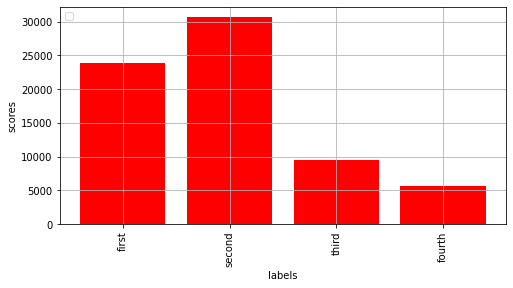

In [82]:
y_quad = list(map(len, [first_quad, second_quad, third_quad, fourth_quad]))

print(y_quad)
simple_bar(['first', 'second', 'third', 'fourth'], y_quad, size=(8, 4))

---
# **8. CATEGORIES**
---
There are four quadrants plus 3D called dominance (README.md)

In [83]:
def find_word(word, df, c='word'):
    return df[df[c].str.contains(word)]

### Confident
- confident -> trust
- unconfident -> disgust

In [84]:
confident = trust

In [85]:
unconfident = disgust

In [86]:
confident['category'] = 'confident'
unconfident['category'] = 'unconfident'

# NOTE
# this where just based on the Wheel of emotions (R. Plutchik)
# as trust and disgust where opposites

### Handles pressure
In the positive side is included patience, focus and calm
- POS : dominance strong + low arousal + positive valence
- NEG : dominance weak + high arousal + negative valence

In [87]:
# Dominance: drop every weak feature
pos_hp = fourth_quad
pos_hp = pos_hp[(pos_hp['Dominance'] >= midpoint_VAD)]

In [88]:
# opposite quadrante (opposite to IV -> II)
neg_hp = second_quad
neg_hp = neg_hp[(neg_hp['Dominance'] <= midpoint_VAD)]

In [89]:
pos_hp['category'] = 'pos hp'
neg_hp['category'] = 'neg hp'

### Organized
- POS : anticipation + high arousal + positive valence   
- NEG : surprise + low arousal + negative valence

In [90]:
organized = concat([anticipation, first_quad])

In [91]:
unorganized = concat([surprise, third_quad])

In [92]:
organized['category'] = 'organized'
unorganized['cateogory'] = 'unorgnized'

### Interested
- POS : [anticipation] + high arousal + positive valence
- NEG : [surprise] + low arousal + negative valence

In [93]:
interested = anticipation

# NOTE
# this where just based on the Wheel of emotions (R. Plutchik)
# as anticipation and surprise where opposites.
# And each events are: 
# vigilance --> anticipation --> [interest]
# amazement --> surprise --> [distraction]

In [94]:
uninterested = surprise

In [95]:
interested['category'] = 'interested'
uninterested['category'] = 'uninterested'

### Happy
- POS : joy + high arousal + positive valence
- NEG : sadness + low arousal + negative valence

In [96]:
happy = joy

In [97]:
unhappy = sadness

In [98]:
happy['category'] = 'happy'
unhappy['category'] = 'unhappy'

### Friendly
- POS : high arousal + positive valence + (positive) + (joy + trust)
- NEG : anger + high arousal + negative valence

In [99]:
friendly = concat([joy, trust, positive])

In [100]:
unfriendly = concat([anger, disgust, negative])

In [101]:
friendly['category'] = 'friendly'
unfriendly['category'] = 'unfriendly'

## Dataset

### Concatenating categories dataframe

In [102]:
categories_datasets = [confident, unconfident, pos_hp, neg_hp, interested, uninterested, happy, unhappy, friendly, unfriendly]
df_categories = concat(categories_datasets)

In [103]:
df_categories.replace(float('NaN'), '--', inplace=True)

### To CSV

In [104]:
df_categories.to_csv('datasets/categories_dataset.csv', encoding='utf-8', index=True)

In [105]:
# drop duplicates: should be for each quadrant
# is not an option
!mkdir 'test'
df_categories_dropdup = df_categories.drop_duplicates(subset=['word'], keep=False, ignore_index=True)
df_categories_dropdup.to_csv('test/categories_set.csv', encoding='utf-8', index=False)

In [106]:
df_categories_dropdup.to_csv('test/categories_set.csv', encoding='utf-8', index=False)

## PLOT Categories

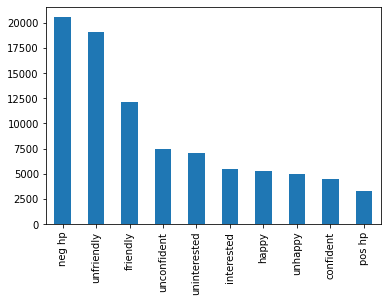

In [107]:
df_categories['category'].value_counts().plot(kind='bar')

#### POSITIVE

No handles with labels found to put in legend.


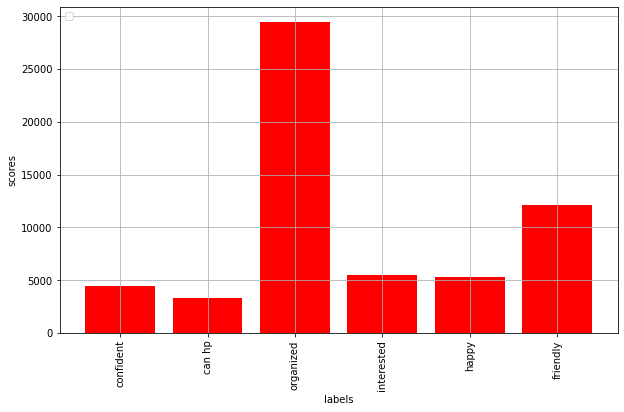

In [108]:
simple_bar(
    x=['confident', 'can hp', 'organized', 'interested', 'happy', 'friendly'],
    y=list(map(len, [confident, pos_hp, organized, interested, happy, friendly])),
    size=(10, 6)
)

#### NEGETIVE

No handles with labels found to put in legend.


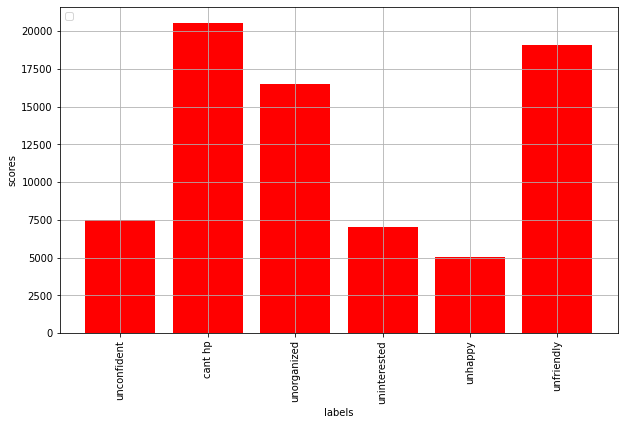

In [109]:
simple_bar(
    x=['unconfident', 'cant hp', 'unorganized', 'uninterested', 'unhappy', 'unfriendly'],
    y=list(map(len, [unconfident, neg_hp, unorganized, uninterested, unhappy, unfriendly])),
    size=(10, 6)
)

---
# **9. POS (Part Of the Speech)**
---
- using POS from stanza and nltk treebank
- then comparing the results

## Stanza POS

In [110]:
df = df_categories

In [111]:
def stanza_pos(text):
    doc = stNLP(text)
    for sent in doc.sentences:
        for word in sent.words:
            return word.upos

In [112]:
df.replace('', float('NaN'), inplace=True)
df.dropna(subset=['word'], inplace=True)

In [116]:
# uncomment to apply spacy POS
#df['POS stza'] = df['word'].apply(lambda x: stanza_pos(text=x))

## NLTK treebank POS

In [115]:
def nltk_pos(text):
    # pos_tag comes in as capital letters i.e. 'JJR' or 'NN'
    tag_dict = {"J": "ADJ", "N": "NOUN", "V": "VERB", "R": "ADV"}

    token = word_tokenize(text)
    pos_tag = (nltk.pos_tag(token)[0])[1]

    # returns NOUN if the pos_tag[0] doesn't exist in tag_dict
    return tag_dict.get(pos_tag[0], 'NOUN')

In [117]:
# uncomment to apply spacy POS
#df['POS nlkt'] = df['word'].apply(lambda x: nltk_pos(text=x))

## Spacy POS

In [118]:
def spacy_pos(text):
    for token in spNLP(text):
        return token.pos_

In [119]:
# uncomment to apply spacy POS
# df['POS spcy'] = df['word'].apply(lambda x: spacy_pos(x))

In [120]:
# comment to apply spacy POS
df = pd.read_csv(io.StringIO(request_csv(spacy_checkpoint)), sep=',', encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Final processing

In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
df = df.drop(columns=['score', 'quadrant'])

In [126]:
df = df.astype(str) 
for column in list(df.columns):
    df = df.drop(df[(df[column] == '--')].index)

In [127]:
# Changing all float numbers using only two decimals
for column in ['Compound', 'Subjectivity', 'Stanza', 'Valence', 'Arousal', 'Dominance']:
    df[column] = df[column].apply(lambda x: round(float(x), 2))

## Min Counter from df.category

In [145]:
count_categories = dict(Counter(df.category))
min_count_categories = min(list(count_categories.values()))

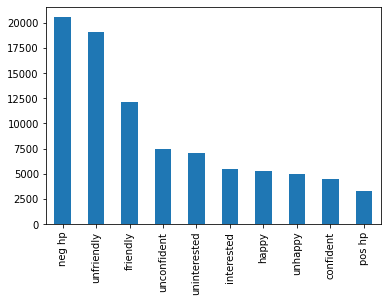

In [149]:
df['category'].value_counts().plot(kind='bar')

## 1000 samples or min categories
- 100 per 10 categories
- min_catergory per 10 categories

In [150]:
df_2 = pd.DataFrame(columns=list(df.columns))

In [151]:
df_2

,category,word,Compound,Subjectivity,Stanza,Flair,Valence,Arousal,Dominance,POS stza,POS nlkt,POS spcy


In [152]:
def append_new_df(df, df_2, s, n):
    c = 1
    for index, row in df.iterrows():
        if s == row[0]:
            if c <= n:
                df_2 = df_2.append(row)
                c += 1
    return df_2

In [153]:
df_2 = pd.DataFrame()
n = min_count_categories #100

for s in sorted(list(set(df.category))):
    df_2 = append_new_df(df, df_2, s, n=n)

In [154]:
Counter(df_2['category'])

Counter({'confident': 3266,
         'friendly': 3266,
         'happy': 3266,
         'interested': 3266,
         'neg hp': 3266,
         'pos hp': 3266,
         'unconfident': 3266,
         'unfriendly': 3266,
         'unhappy': 3266,
         'uninterested': 3266})

In [162]:
balanced_name = 'categories_dataset_min_counter' # 'categories_dataset_1000.csv'
df_2.to_csv(path_or_buf=balanced_name+'.csv', encoding='utf-8', index=True)

## checking data types and nan

In [156]:
df.dtypes

category         object
word             object
Compound        float64
Subjectivity    float64
Stanza          float64
Flair            object
Valence         float64
Arousal         float64
Dominance       float64
POS stza         object
POS nlkt         object
POS spcy         object
dtype: object

In [157]:
# checking for nan values & filling them with 0
check_nan = [i for i in (df.isnull().any()) if i == True]
try:
    check_nan.index(True)
    #df.fillna(value=0, inplace=True)
except:
    print('No NaN values found\n')
finally:
    print(df.isna().any())

No NaN values found

category        False
word            False
Compound        False
Subjectivity    False
Stanza          False
Flair           False
Valence         False
Arousal         False
Dominance       False
POS stza        False
POS nlkt        False
POS spcy        False
dtype: bool


## Plot

In [158]:
# histogram
from collections import Counter

def words_histogram(text_arr, N=100, figsize=(8, 16)):
    text = ' '.join([str(elem) for elem in text_arr])

    words = text.split()
    counts = Counter(words)
    serie = pd.Series(counts) # convert dictionary to pandas.Series.object

    # sort the values (in ascending order) of the serie and sleect the N most frequent words
    first_N = serie.sort_values().tail(N) # simmilar to most_common but most efficient, because calculates the frequencies just once

    ax = first_N.plot.barh(figsize=figsize) # make the horizontal bar plot, set the size of the figure
    i = 0
    xoffset = .1 # value to adjust the text label

    for v in first_N.values:
        # adds the text next to each bar
        ax.text(y=i, x=v + xoffset, s=v, ha='left', va='center')
        i += 1

In [159]:
x_train = np.array(list(df.word), dtype='<U33')

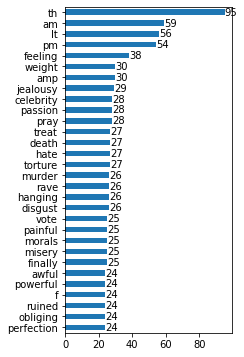

In [160]:
words_histogram(text_arr=x_train, N=30, figsize=(3, 6))

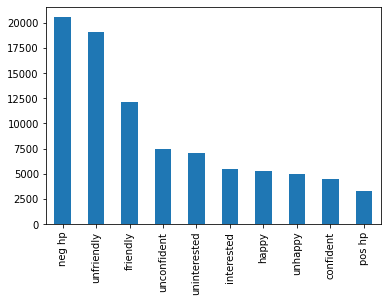

In [161]:
df['category'].value_counts().plot(kind='bar')

## to csv

In [ ]:
df.to_csv('categories_dataset.csv', encoding='utf-8', index=True)